In [1]:
import ast
import re
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim
import math

In [ ]:
# """Data loading and preprocessing for knot datasets. Run only once to create the dataset file."""

# def fix_mathematica_notation(line: str) -> str:
#     # Fix *^ to Python's e notation
#     return re.sub(r'\*\^\s*([-+]?\d+)', r'e\1', line)

# def parse_line(line: str):
#     # Fix notation
#     line = fix_mathematica_notation(line)
#     # Replace `{}` with `()`
#     line_py = line.replace('{', '(').replace('}', ')')
#     # Parse safely with literal_eval
#     data = ast.literal_eval(line_py)
#     _, input_list, target_list, _ = data
#     X_in = torch.tensor(input_list, dtype=torch.float32)
#     X_tar = torch.tensor(target_list, dtype=torch.float32)
#     return X_in, X_tar


# input_file = "nameJ2zerosJ3zerosvol.txt"   # <-- your original txt file
# output_file = "knots_dataset.pt"

# dataset = []
# with open(input_file) as f:
#     for i, line in enumerate(f):
#         line_fixed = fix_mathematica_notation(line)
#         X_in, X_tar = parse_line(line_fixed)
#         dataset.append((X_in, X_tar))
#         if i < 3:  # show some confirmation
#             print(f"Example {i}: X_in shape {X_in.shape}, X_tar shape {X_tar.shape}")

# torch.save(dataset, output_file)
# print(f"\n Saved {len(dataset)} pairs to {output_file}")

In [2]:
class KnotsDataset(Dataset):
    def __init__(self, pt_path):
        self.data = torch.load(pt_path)
        # adapt depending on your saved format
        # For example, assume self.data is a list of (X_in, X_tar)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]  # returns (X_in, X_tar)

dataset = KnotsDataset('knots_dataset.pt')

In [3]:
def knots_collate_fn(batch):
    """
    batch: list of (X_in, X_tar)
    - X_in: [N_in, 2]
    - X_tar: [N_tar, 2]  # no confidence yet!

    Returns:
      X_in_padded: (B, max_N_in, 2)
      mask_in: (B, max_N_in)
      X_tar_padded_with_conf: (B, max_N_tar, 3)
    """
    X_in_list, X_tar_list = zip(*batch)

    # Input padding + mask
    X_in_padded = pad_sequence(X_in_list, batch_first=True, padding_value=0.0)
    mask_in = torch.zeros(X_in_padded.shape[:2], dtype=torch.bool)
    for i, x in enumerate(X_in_list):
        mask_in[i, :x.size(0)] = True

    # Target padding + confidence
    X_tar_padded = pad_sequence(X_tar_list, batch_first=True, padding_value=0.0)

    B, max_N_tar, _ = X_tar_padded.shape

    # Add confidence dimension:
    X_tar_with_conf = torch.zeros(B, max_N_tar, 3)
    X_tar_with_conf[:, :, :2] = X_tar_padded

    for i, x in enumerate(X_tar_list):
        L = x.size(0)
        X_tar_with_conf[i, :L, 2] = 1.0  # confidence = 1 for real points

    return X_in_padded, mask_in, X_tar_with_conf


In [4]:
batch_size = 32
num_workers = 2

# Create indices for splitting
indices = list(range(len(dataset)))
train_indices, valtest_indices = train_test_split(indices, test_size=0.2, random_state=42)
val_indices, test_indices = train_test_split(valtest_indices, test_size=0.5, random_state=42)

# Use Subset to create datasets for splits
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Make DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, collate_fn=knots_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,
                        num_workers=num_workers, collate_fn=knots_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,
                         num_workers=num_workers, collate_fn=knots_collate_fn)

In [5]:
class DeepSets(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=128, num_outputs=49):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.pooling = lambda x, mask: torch.sum(x * mask.unsqueeze(-1), dim=1)        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_outputs * 3)  # (x, y, confidence)
        )
        self.num_outputs = num_outputs

    def forward(self, x, mask):
        encoded = self.encoder(x)                        # (B, L, hidden_dim)
        pooled = self.pooling(encoded, mask)             # (B, hidden_dim)
        decoded = self.decoder(pooled)                   # (B, num_outputs * 3)
        decoded = decoded.view(-1, self.num_outputs, 3)  # (B, M, 3)
        decoded[..., 2] = decoded[..., 2].sigmoid() 
        return decoded

In [6]:
class MAB(nn.Module):
    """Multihead Attention Block with mask support."""
    def __init__(self, dim_Q, dim_KV, hidden_dim, num_heads):
        super().__init__()
        self.fc_q = nn.Linear(dim_Q, hidden_dim)
        self.fc_k = nn.Linear(dim_KV, hidden_dim)
        self.fc_v = nn.Linear(dim_KV, hidden_dim)
        self.mha = nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)
        self.ln0 = nn.LayerNorm(hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ff = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, Q, K, key_mask=None):
        Q_proj = self.fc_q(Q)
        K_proj = self.fc_k(K)
        V_proj = self.fc_v(K)
        attn_output, _ = self.mha(Q_proj, K_proj, V_proj, key_padding_mask=key_mask)
        H = self.ln0(Q_proj + attn_output)
        H = self.ln1(H + self.ff(H))
        return H

class ISAB(nn.Module):
    """Induced Set Attention Block with mask support."""
    def __init__(self, dim_in, hidden_dim, num_heads, num_inds):
        super().__init__()
        self.I = nn.Parameter(torch.randn(1, num_inds, hidden_dim))
        self.mab1 = MAB(hidden_dim, dim_in, hidden_dim, num_heads)
        self.mab2 = MAB(dim_in, hidden_dim, hidden_dim, num_heads)

    def forward(self, X, mask=None):
        H = self.mab1(self.I.repeat(X.size(0), 1, 1), X, key_mask=mask)
        return self.mab2(X, H)

class Encoder(nn.Module):
    """Encodes input points with mask."""
    def __init__(self, dim_in=2, hidden_dim=128, num_heads=4, num_layers=2):
        super().__init__()
        self.layers = nn.ModuleList([
            ISAB(dim_in if i == 0 else hidden_dim, hidden_dim, num_heads, num_inds=16)
            for i in range(num_layers)
        ])

    def forward(self, X, mask):
        H = X
        key_mask = ~mask.bool()
        for layer in self.layers:
            H = layer(H, key_mask)
        return H

class CrossDecoder(nn.Module):
    """Uses input-conditioned queries + slot embeddings."""
    def __init__(self, hidden_dim=128, num_heads=4, num_outputs=64):
        super().__init__()
        self.num_outputs = num_outputs
        self.slot_emb = nn.Parameter(torch.randn(num_outputs, hidden_dim))
        self.query_gen = nn.Linear(hidden_dim, hidden_dim)
        self.cross_attn = MAB(hidden_dim, hidden_dim, hidden_dim, num_heads)
        self.post = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3)  # [x, y, confidence]
        )

    def forward(self, H, mask):
        pooled = H.mean(dim=1)  # (B, hidden_dim)
        base_query = self.query_gen(pooled)  # (B, hidden_dim)
        Q = base_query.unsqueeze(1) + self.slot_emb.unsqueeze(0)  # (B, num_outputs, hidden_dim)
        key_mask = ~mask.bool()
        Z = self.cross_attn(Q, H, key_mask)
        out = self.post(Z)
        out_xy = out[..., :2]
        out_conf = torch.sigmoid(out[..., 2:3])
        return torch.cat([out_xy, out_conf], dim=-1)

class SetTransformer(nn.Module):
    """Full set-to-set predictor."""
    def __init__(self, dim_input=2, hidden_dim=128, num_outputs=64, num_heads=4):
        super().__init__()
        self.encoder = Encoder(dim_input, hidden_dim, num_heads)
        self.decoder = CrossDecoder(hidden_dim, num_heads, num_outputs)

    def forward(self, X, mask):
        H = self.encoder(X, mask)
        Y = self.decoder(H, mask)
        return Y

In [7]:
class VecChamferLoss(nn.Module):
    def __init__(self, lambda_coord=1.0, lambda_conf=1.0, lambda_reg=0.1, alpha=10.0):
        super().__init__()
        self.lambda_coord = lambda_coord
        self.lambda_conf = lambda_conf
        self.lambda_reg = lambda_reg
        self.alpha = alpha  # sharpness for soft targets

    def forward(self, pred_tensor, target_tensor):
        """
        pred_tensor: (B, M, 3) - (x, y, confidence logits)
        target_tensor: (B, N, 3) - (x, y, confidence in [0, 1])
        """

        # Separate coordinates and confidences
        pred_xy = pred_tensor[..., :2]                # (B, M, 2)
        pred_conf = pred_tensor[..., 2]  # (B, M) in [0, 1]

        target_xy = target_tensor[..., :2]            # (B, N, 2)
        target_conf = target_tensor[..., 2]           # (B, N) in [0, 1]

        # Pairwise Euclidean distances
        dists = torch.cdist(pred_xy, target_xy, p=2)  # (B, M, N)

        # Mask: which target points are valid
        mask_target = (target_conf > 0.5)  # (B, N)

        # Mask out padded targets by setting distances to +inf
        dists_masked = dists.masked_fill(~mask_target.unsqueeze(1), float('inf'))

        # Chamfer direction: pred -> target (each pred finds closest real target)
        min_pred_to_target, _ = dists_masked.min(dim=2)  # (B, M)

        # Chamfer direction: target -> pred (each real target finds closest pred)
        min_target_to_pred, _ = dists_masked.min(dim=1)  # (B, N)
        
        min_target_to_pred = torch.nan_to_num(min_target_to_pred * mask_target)  # zero out padded

        # Weighted Chamfer loss (mean over valid points)
        chamfer_pred = (pred_conf * min_pred_to_target).sum(dim=1) / (pred_conf.sum(dim=1) + 1e-8)
        chamfer_target = min_target_to_pred.sum(dim=1) / (mask_target.sum(dim=1) + 1e-8)

        chamfer_loss = chamfer_pred.mean() + chamfer_target.mean()

        # Soft target confidence: encourage pred_conf ~ max similarity to real targets
        soft_target_conf = torch.exp(-self.alpha * dists**2)  # (B, M, N)
        soft_target_conf = soft_target_conf * mask_target.unsqueeze(1)  # zero out padded
        conf_targets = soft_target_conf.max(dim=2)[0]  # (B, M)

        conf_loss = F.binary_cross_entropy(pred_conf, conf_targets)

        # Penalize high conf
        reg_loss = (pred_conf ** 2).mean()

        # Total loss
        total_loss = (self.lambda_coord * chamfer_loss
                      + self.lambda_conf * conf_loss
                      + self.lambda_reg * reg_loss)

        return total_loss

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
model = SetTransformer(hidden_dim=512).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = VecChamferLoss(lambda_coord=2.5, lambda_conf=1.0, lambda_reg=.5, alpha=20.0)
num_epochs = 20

best_val_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for x_tensor, x_mask, y_tensor in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train"):
        x_tensor = x_tensor.to(device)
        x_mask = x_mask.to(device)
        y_tensor = y_tensor.to(device)

        pred_tensor = model(x_tensor, x_mask)
        loss = loss_fn(pred_tensor, y_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_tensor, x_mask, y_tensor in val_loader:
            x_tensor = x_tensor.to(device)
            x_mask = x_mask.to(device)
            y_tensor = y_tensor.to(device)

            pred_tensor = model(x_tensor, x_mask)
            loss = loss_fn(pred_tensor, y_tensor)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

torch.save(best_model_state, "best_model.pt")


Epoch 1/20 - Train: 100%|██████████| 4433/4433 [21:32<00:00,  3.43it/s]


Epoch 1 - Train Loss: 1.0228 - Val Loss: 0.8236


Epoch 2/20 - Train:  90%|█████████ | 3997/4433 [19:47<02:19,  3.13it/s]

In [14]:
torch.save(model.state_dict(), "deepsets_model.pt")

In [15]:
# Load model
model = DeepSets(hidden_dim=512).to(device)
model.load_state_dict(torch.load("deepsets_model.pt", map_location=device))
model.eval()


DeepSets(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=147, bias=True)
  )
)

In [13]:
def plot_batch_pred_vs_actual(pred_tensor, y_tensor, n=4, show_confidence=True, threshold=0.05):
    """
    Plot side-by-side subplots of predicted vs actual points.

    Parameters:
    - pred_tensor: (B, M, 3) — predicted [x, y, confidence]
    - y_tensor: (B, M, 3) — ground truth [x, y, confidence]
    - n: int — number of batch elements to plot
    - show_confidence: bool — whether to use confidence as alpha for predicted
    """
    pred_tensor = pred_tensor.detach().cpu()
    y_tensor = y_tensor.detach().cpu()

    batch_size = pred_tensor.shape[0]
    n = min(n, batch_size)

    cols = min(n, 4)
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = axes.flatten()

    for i in range(n):
        pred_coords = pred_tensor[i, :, :2].numpy()
        pred_conf = pred_tensor[i, :, 2].numpy()

        true_coords = y_tensor[i, :, :2].numpy()
        true_conf = y_tensor[i, :, 2].numpy()
        true_coords = true_coords[true_conf > 0]

        ax = axes[i]
        ax.scatter(true_coords[:, 0], true_coords[:, 1], c='blue', label='Actual', alpha=0.6)
        if show_confidence:
            ax.scatter(pred_coords[:, 0], pred_coords[:, 1], c='red', alpha=pred_conf.clip(threshold, 1.0), label='Predicted')
        else:
            ax.scatter(pred_coords[:, 0], pred_coords[:, 1], c='red', label='Predicted')

        ax.set_title(f'Example {i}')
        ax.axis('equal')
        ax.grid(True)

    # Turn off unused axes
    for j in range(n, len(axes)):
        axes[j].axis('off')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.show()


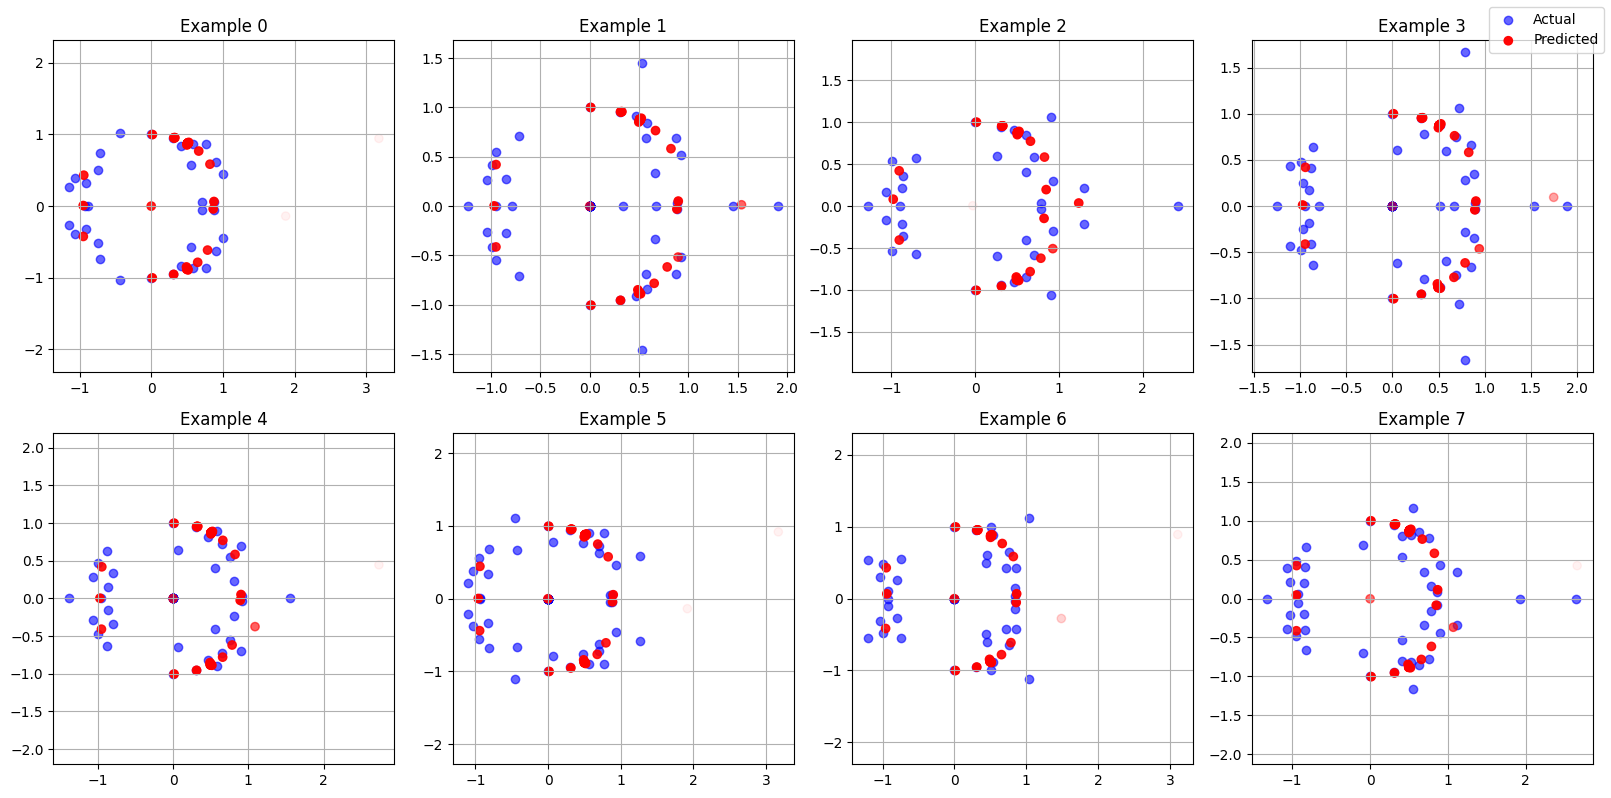

In [14]:
with torch.no_grad():
    model.eval()
    for x_tensor, x_mask, y_tensor in test_loader:
        x_tensor = x_tensor.to(device)
        x_mask = x_mask.to(device)
        y_tensor = y_tensor.to(device)

        pred_tensor = model(x_tensor, x_mask)
        plot_batch_pred_vs_actual(pred_tensor, y_tensor, n=8)
        break
